# Assignment 4: Block Matching and Harris Corner Detection
## Ex. 4.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "racecar" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

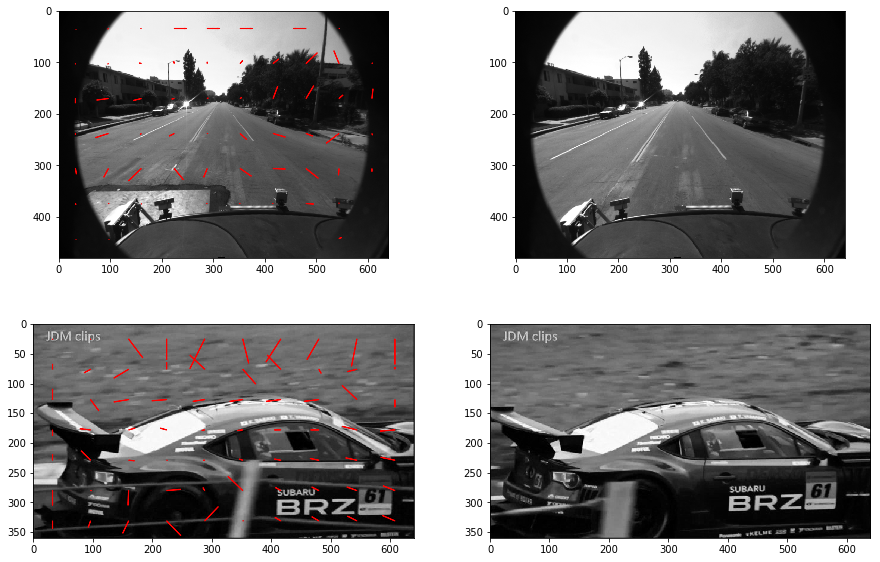

In [42]:
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io, data, feature, color
import numpy as np
import math

def findMatch(block, blockLeft, newImage):
    neighbourhood = 25
    blockWidth = block.shape[1]
    blockHeight = block.shape[0]
    blockCenter = (blockLeft[0] + int(round(blockWidth/2)), 
                   blockLeft[1] + int(round(blockHeight/2)))
    
    minDif = math.inf
    match =  blockCenter
    
    neighbourhoodStartX = max(0, blockLeft[0] -  neighbourhood)
    neighbourhoodStartY = max(0, blockLeft[1] -  neighbourhood)
    
    for x in range(neighbourhood+neighbourhood):
        for y in range(neighbourhood+neighbourhood): # todo Bild cap
            ##oberer Rand, unterer Rand, linkerRand, rechter Rand
            currentNewLeft = (neighbourhoodStartX+x, neighbourhoodStartY+y)        
            currentNewBlock = newImage[currentNewLeft[1]:currentNewLeft[1]+blockHeight,
                                       currentNewLeft[0]: currentNewLeft[0]+blockWidth]
            
            # x Richtung, axis 1 
            padding_x = block.shape[1] - currentNewBlock.shape[1]
            # y Richtung, axis 0 
            padding_y = block.shape[0] - currentNewBlock.shape[0]  
            
            
            currentNewBlock = np.pad(currentNewBlock, ((0,padding_y), (0,padding_x)), 'constant')
            #try:
            newDiff = np.sum((block-currentNewBlock)**2)
            
            #newDiff = sumSquaredDiff(block, currentNewBlock)
            if newDiff < minDif:
                minDif = newDiff
                currentNewCenter = (currentNewLeft[0] + int(round(blockWidth/2)), 
                                    currentNewLeft[1] + int(round(blockHeight/2)))
                match = currentNewCenter
    
    return match

def blockMatching(oldImage, newImage, out=plt):
    image_width = oldImage.shape[1]
    countBlocksX = 10
    blockSizeX = int(math.floor(image_width/countBlocksX))

    image_height = oldImage.shape[0]
    countBlocksY = 7
    blockSizeY = int(math.floor(image_height/countBlocksY))

    for currentBlockX in range(countBlocksX):
        x = currentBlockX * blockSizeX
        for currentBlockY in range(countBlocksY): 
            y = currentBlockY * blockSizeY
            block = oldImage[y:y+blockSizeY, x:x+blockSizeX] #oberer Rand, unterer Rand, linkerRand, rechter Rand
            centerOldX, centerOldY = (x+blockSizeX//2, y+blockSizeY//2)
            centerOfMatchX, centerOfMatchY = findMatch(block, (x, y), newImage)
            dx, dy = (centerOfMatchX-centerOldX, centerOfMatchY - centerOldY)
            out.add_patch(
                patches.Arrow(centerOldX, centerOldY, dx, dy, edgecolor="red")
            )
            
# chose other images if you like
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00001.png')

car1 = io.imread('images/racecar/100.jpeg')
car2 = io.imread('images/racecar/102.jpeg') 

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

lane1 = color.rgb2gray(lane1)
lane2 = color.rgb2gray(lane2)


blockMatching(lane1, lane2, ax11)

car1 = color.rgb2gray(car1)
car2 = color.rgb2gray(car2)

blockMatching(car1, car2, ax21)

ax11.imshow(color.gray2rgb(lane1))
ax12.imshow(color.gray2rgb(lane2))

ax21.imshow(color.gray2rgb(car1))
ax22.imshow(color.gray2rgb(car2))

## Ex. 4.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture
* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)

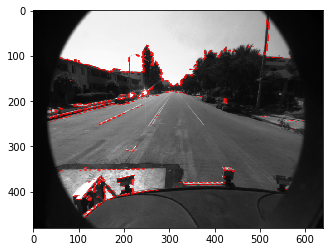

In [36]:
import cv2

def calculateGradients(imgGrey):
    gradients = np.zeros((imgGrey.shape[0], imgGrey.shape[1], 2)) 
    for h in range(1, imgGrey.shape[0]-1):
        for w in range(1, imgGrey.shape[1]-1):
            gradients[h][w][0] = (imgGrey[h][w+1] - imgGrey[h] [w-1])/2
            gradients[h][w][1] = (imgGrey[h-1][w] - imgGrey[h+1][w])/2
    
    return gradients
                
def findCorners(image):
    imgGrey = color.rgb2gray(image)
    gradientX, gradientY =  np.gradient(imgGrey)
    k = 0.05 # 0.04 - 0.06
    gradientX_2 = gradientX*gradientX
    gradientY_2 = gradientY*gradientY
    gradientYX  = gradientX*gradientY
    detector =  gradientX_2*gradientY_2 - \
                gradientYX*gradientYX - \
                k * (gradientX_2 + gradientY_2)
            
    threshold = -0.0015
    detectorMask = detector < threshold
    corners = np.zeros(image.shape, dtype=np.uint8)
    corners[detectorMask] = [255,255,255]
    #plt.imshow(corners)
       
    cornerList = []
    for y in range(detectorMask.shape[0]):
        for x in range(detectorMask.shape[1]):
            if detectorMask[y][x]: 
                point = [np.array([x, y], dtype=np.float32)]
                cornerList.append(np.array(point))
    cornerList = np.array(cornerList)
    
    #todo non maximum suppression
    
    return cornerList
    

def trackLane():
    
    lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    lane1 = io.imread('images/lane_detection/f00000.png')
    lane1Grey = color.rgb2gray(lane1)
    frame1_gray = np.uint8(lane1Grey)

    lane2 = io.imread('images/lane_detection/f00001.png')
    lane2Grey = color.rgb2gray(lane2)
    frame2_gray = np.uint8(lane1Grey)
    
    img0, img1 = frame1_gray, frame2_gray
    corners = findCorners(lane1)

    flow_matches, _st, _err = cv2.calcOpticalFlowPyrLK(img0, img1, corners, None, **lk_params) 
        
    currentAxis = plt.gca()
    for new, old in zip(flow_matches, corners):
        old_x, old_y = old[0]
        new_x, new_y = new[0]
        dx, dy = (new_x-old_x, new_y - old_y)
        currentAxis.add_patch(
            patches.Arrow(old_x, old_y, dx, dy, edgecolor="red")
        )
    
    lane1Grey = color.gray2rgb(lane1Grey)
    plt.imshow(lane1Grey)
    
trackLane()